In [19]:
import tensorflow as tf
import matplotlib.pyplot as plt
import requests
import numpy as np
import csv
import os
from tensorflow.python.framework import ops

In [14]:
birth_weight_file = "../data/birthweight.dat"
if not os.path.exists(birth_weight_file):
    birthdata_url = "https://raw.githubusercontent.com/nfmcclure/" \
        "tensorflow_cookbook/master/01_Introduction/07_Working_with_Data_Sources/" \
        "birthweight_data/birthweight.dat"
    birth_file = requests.get(birthdata_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x) >= 1]
        for y in birth_data[1:] if len(y) >= 1]
    with open(birth_weight_file, "w") as f:
        writer = csv.writer(f)
        writer.writerow(birth_header)
        writer.writerows(birth_data)
        
birth_data = []
with open(birth_weight_file, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    birth_header = next(csv_reader)
    for row in csv_reader:
        birth_data.append([float(x) for x in row])
        
y_vals = np.array([x[8] for x in birth_data])
cols_of_interest = ["AGE", "LWT", "RACE", "SMOKE", "PTL", "HT", "UI"]
x_vals = np.array([[x[ix] for ix, feature in enumerate(birth_header)
    if feature in cols_of_interest] for x in  birth_data])

In [15]:
seed = 3
tf.set_random_seed(seed)
np.random.seed(seed)

train_indices = np.random.choice(len(x_vals), round(len(x_vals) * 0.8),
                                replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m - col_min) / (col_max - col_min)

x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

In [37]:
ops.reset_default_graph()
with tf.Session() as sess:
    def init_weight(shape, st_dev):
        weight = tf.Variable(tf.random_normal(shape, stddev=st_dev))
        return weight
    def init_bias(shape, st_dev):
        bias = tf.Variable(tf.random_normal(shape, stddev=st_dev))
        return bias
    def fully_connected(input_layer, weights, biases):
        layer = tf.add(tf.matmul(input_layer, weights), biases)
        return tf.nn.relu(layer)
    
    bs = 100
    lr = 0.05
    it = 200
    x_data = tf.placeholder(shape=[None, 7], dtype=tf.float32)
    y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
    
    weight_1 = init_weight(shape=[7, 25], st_dev=10.0)
    bias_1 = init_bias(shape=[25], st_dev=10.0)
    layer_1 = fully_connected(x_data, weight_1, bias_1)
    
    weight_2 = init_weight(shape=[25, 10], st_dev=10.0)
    bias_2 = init_bias(shape=[10], st_dev=10.0)
    layer_2 = fully_connected(layer_1, weight_2, bias_2)
    
    weight_3 = init_weight(shape=[10, 3], st_dev=10.0)
    bias_3 = init_bias(shape=[3], st_dev=10.0)
    layer_3 = fully_connected(layer_2, weight_3, bias_3)
    
    weight_4 = init_weight(shape=[3, 1], st_dev=10.0)
    bias_4 = init_bias(shape=[1], st_dev=10.0)
    final_output = fully_connected(layer_3, weight_4, bias_4)
    
    loss = tf.reduce_mean(tf.abs(y_target - final_output))
    my_opt = tf.train.AdamOptimizer(lr)
    train_step = my_opt.minimize(loss)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    loss_vec = []
    test_loss = []
    for i in range(it):
        rand_index = np.random.choice(len(x_vals_train), size=bs)
        rand_x = x_vals_train[rand_index]
        rand_y = np.transpose([y_vals_train[rand_index]])
        sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
        temp_loss = sess.run(loss, feed_dict={
            x_data: rand_x,
            y_target: rand_y})
        loss_vec.append(temp_loss)
        test_temp_loss = sess.run(loss, feed_dict={
            x_data: x_vals_test,
            y_target: np.transpose([y_vals_test])})
        test_loss.append(test_temp_loss)
        
        if (i + 1) % 25 == 0:
            print('Generation: ' + str(i + 1) + ', Loss = ' + str(temp_loss))
    
    actuals = np.array([1.0 if x[8] < 2500 else 0.0 for x in birth_data])
    test_actuals = actuals[test_indices]
    train_actuals = actuals[train_indices]
    test_preds = [1.0 if x[0] < 2500 else 0.0 for x in sess.run(final_output, feed_dict={
        x_data: x_vals_test
    })]
    train_preds = [1.0 if x[0] < 2500 else 0.0 for x in sess.run(final_output, feed_dict={
        x_data: x_vals_train
    })]
    test_acc = np.mean([x == y for x, y in zip(test_preds, test_actuals)])
    train_acc = np.mean([x == y for x, y in zip(train_preds, train_actuals)])
    print('On predicting the category of low birthweight from regression output (<2500g):')
    print('Test Accuracy: {}'.format(test_acc))
    print('Train Accuracy: {}'.format(train_acc))

Generation: 25, Loss = 2049.4568
Generation: 50, Loss = 1208.3578
Generation: 75, Loss = 1077.4053
Generation: 100, Loss = 710.1328
Generation: 125, Loss = 703.52484
Generation: 150, Loss = 766.4473
Generation: 175, Loss = 680.4487
Generation: 200, Loss = 674.52435
On predicting the category of low birthweight from regression output (<2500g):
Test Accuracy: 0.7631578947368421
Train Accuracy: 0.7814569536423841


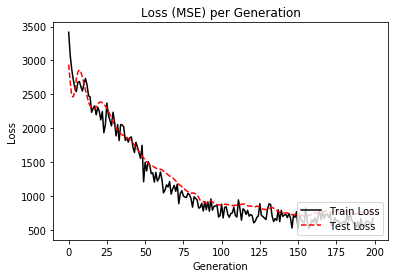

In [38]:
plt.plot(loss_vec, 'k-', label='Train Loss')
plt.plot(test_loss, 'r--', label='Test Loss')
plt.title('Loss (MSE) per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()